In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
import time
import datetime as dt
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
def fn_load_kaggle_dataset(kaggle_path, destination=os.getcwd()):
        
    # Authenticate Kaggle API
    api = KaggleApi()
    api.authenticate()

    # Download the dataset
    api.dataset_download_files(kaggle_path, path=destination, unzip=True)

    #List the name of the csv filenames and pick the first one
    csv_files = [file for file in os.listdir(destination) if file.endswith('.csv')]


    # Load the downloaded CSV file into a Pandas DataFrame
    csv_file = os.path.join(destination, csv_files[0])
    data = pd.read_csv(csv_file)

    return data

In [5]:
#Load the dataset
kaggle_path = 'minasameh55/king-country-houses-aa'
data = fn_load_kaggle_dataset(kaggle_path=kaggle_path)

Dataset URL: https://www.kaggle.com/datasets/minasameh55/king-country-houses-aa


In [6]:
df = data.copy()

In [7]:
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
df.shape

(21613, 21)

In [9]:
#Add the target variable at the end
target = df.pop('price')
df['price'] = target

In [12]:
df.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price            float64
dtype: object

In [17]:
df.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

In [19]:
df.duplicated().sum()

0

In [21]:
print("View Value Counts Initial : {}".format(df.view.value_counts()))

#Change the view column with the values 0 and 1 representing whether the house has been viewed or not
df['view'] = df['view'].apply([lambda x:x if x == 0 else 1])

print("View Value Counts After : {}".format(df.view.value_counts()))

View Value Counts Initial : view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64
View Value Counts After : view
0    19489
1     2124
Name: count, dtype: int64


In [23]:
#Drop unnecessary columns
df.drop(columns=['id','date'],inplace=True,axis=1)

In [25]:
#Describe the target variable
df['price'].describe().T

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

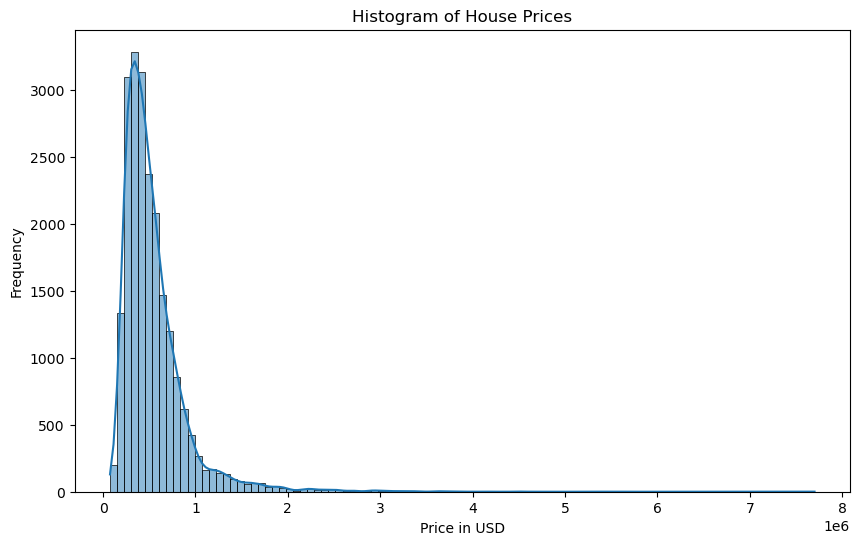

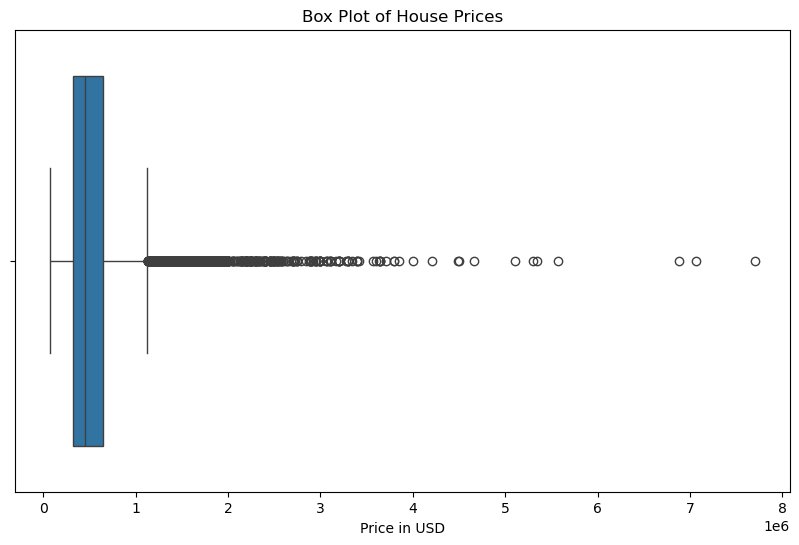

In [27]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=100, kde=True)
plt.title('Histogram of House Prices')
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Box Plot of House Prices')
plt.xlabel('Price in USD')
plt.show()


# Baseline Model

In [30]:
def fn_training_test_split(data, target_variable,test_size=0.3):

    #Split the target and the feature variables
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]
    
    #Split the data frame into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=42)
    
    print("Training Set Size : {}".format(X_train.shape))
    print("Test Set Size : {}".format(X_test.shape))

    return (X_train, X_test, y_train, y_test)

In [32]:
#Training and Testing Split for the baseline models
X_train, X_test, y_train, y_test = fn_training_test_split(data = df, target_variable='price',test_size=0.3)

Training Set Size : (15129, 18)
Test Set Size : (6484, 18)


In [34]:
#Function to train and evaluate the regression models
def fn_model_usage(model_name,model_type,X_train,y_train,X_test):

        #Start Time
        t0 = time.time()

        #Result Metrics
        metrics = {}

        #Fit the model
        model = model_type.fit(X_train, y_train)

        #Predict the result set
        y_pred = model.predict(X_test)

        #Analyse the metrics
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        #Duration in mins
        duration = (time.time()-t0)/60
        
        metrics = {"Model": model_name,
                   "RMSE": rmse,
                   "MAE": mae,
                   "R2 Score": r2,
                   "Exec Time (Mins)": duration}

        return metrics

In [36]:
#Check the baseline models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Ridge CV": RidgeCV(),
    "Lasso CV": LassoCV(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

#Store the model metrics
results = []

# Train and evaluate each model
for name, model in models.items():
    metrics = fn_model_usage(name, model,X_train,y_train,X_test)
    results.append(metrics)


# Convert results to DataFrame
results_df = pd.DataFrame(results)

#Sorted results based on the R2 Score
results_df = results_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

results_df

,Model,RMSE,MAE,R2 Score,Exec Time (Mins)
0,XGBoost,138121.115437,71561.694481,0.867854,0.002324
1,Gradient Boosting,142973.447919,80844.432012,0.858406,0.050654
2,Random Forest,144456.115486,73960.614732,0.855454,0.221874
3,Decision Tree,196855.270427,102211.700571,0.731572,0.003511
4,Linear Regression,208683.184773,127876.867204,0.698346,0.000331
5,Ridge Regression,208719.253247,127874.611911,0.698242,0.000152
6,Ridge CV,208723.726395,127883.320847,0.698229,0.000330
7,Lasso CV,264721.663280,171531.819132,0.514586,0.002493


# Correlation Check - Pearson and Spearman

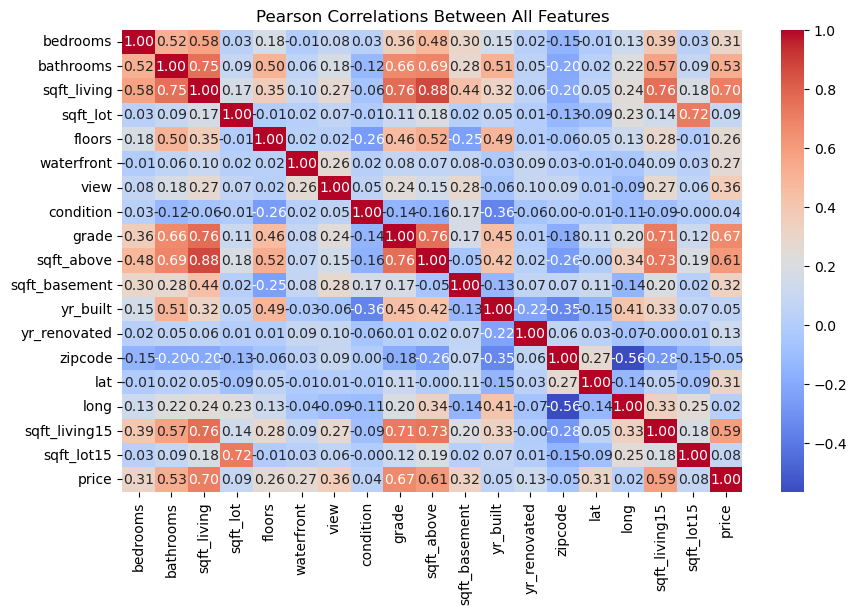

In [38]:
# Compute correlation matrix
correlation_matrix = df.corr(method='pearson')
plt.figure(figsize=(10, 6))
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlations Between All Features")
plt.show()

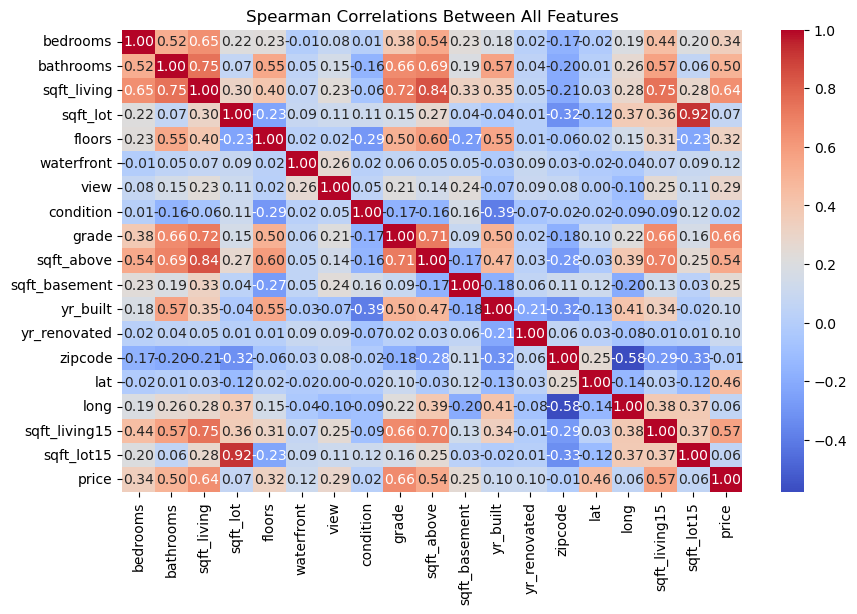

In [39]:
# Compute correlation matrix
correlation_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 6))
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlations Between All Features")
plt.show()

In [40]:
#Check the correlation with the target variables
df.corrwith(df['price'],method='pearson').sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.359120
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
dtype: float64

In [41]:
df.corrwith(df['price'],method='spearman').sort_values(ascending=False)

price            1.000000
grade            0.658215
sqft_living      0.644191
sqft_living15    0.572290
sqft_above       0.541752
bathrooms        0.497160
lat              0.456409
bedrooms         0.344652
floors           0.322347
view             0.290965
sqft_basement    0.251704
waterfront       0.115089
yr_built         0.102038
yr_renovated     0.101876
sqft_lot         0.074939
long             0.063537
sqft_lot15       0.062766
condition        0.018490
zipcode         -0.008735
dtype: float64

# Feature Engineering

In [43]:
# Built two features based on the year of construction and the year of last renovation to the current year
current_year = dt.datetime.now().year
df['yrs_since_built'] = current_year - df['yr_built']
df['yrs_since_lst_renov'] = np.where(df['yr_renovated'] == 0, df['yrs_since_built'], current_year - df['yr_renovated'])
df['renovation_groups'] = np.where((df['yrs_since_lst_renov'] <= 10),1,
                          np.where((df['yrs_since_lst_renov'] > 10) & (df['yrs_since_lst_renov'] <= 20),2,
                          np.where((df['yrs_since_lst_renov'] > 20) & (df['yrs_since_lst_renov'] <= 30),3,
                          np.where((df['yrs_since_lst_renov'] > 30) & (df['yrs_since_lst_renov'] <= 40),4,
                          np.where((df['yrs_since_lst_renov'] > 40) & (df['yrs_since_lst_renov'] <= 50),5,6)))))
                                   
#Does a basement exist
df['basement_flag'] = np.where(df['sqft_basement'] > 0,1,0)
df.sample(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,price,yrs_since_built,yrs_since_lst_renov,renovation_groups,basement_flag
21152,3,2.25,1620,1057,3.0,0,0,3,8,1540,...,98027,47.5396,-122.026,1390,942,450000.0,15,15,2,1
6993,3,2.50,2000,7205,2.0,0,0,3,8,2000,...,98003,47.3499,-122.302,2180,7611,325000.0,26,26,3,0
17959,3,1.00,1010,6400,1.0,0,0,3,7,1010,...,98023,47.3027,-122.376,1820,6500,185000.0,53,53,6,0
4758,4,2.25,2290,5350,2.0,0,0,4,9,2120,...,98199,47.6428,-122.411,2910,5350,975000.0,66,66,6,1
17413,4,2.75,1910,11356,1.0,0,0,5,7,1160,...,98033,47.6999,-122.200,1770,11357,630100.0,47,47,5,1
9504,4,2.50,1970,7098,2.0,0,0,3,7,1970,...,98038,47.3576,-122.058,1970,5361,347500.0,17,17,2,0
6961,3,2.50,1980,9061,2.0,0,0,4,8,1980,...,98074,47.6366,-122.029,1930,8869,550000.0,37,37,4,0
18638,2,1.50,1920,3408,1.0,0,0,4,7,960,...,98122,47.6118,-122.299,1130,3408,517000.0,112,112,6,1
20119,3,3.25,1680,1478,2.0,0,0,3,8,1360,...,98126,47.5674,-122.369,1530,2753,399000.0,15,15,2,1
15703,4,2.50,2590,16437,2.0,0,0,3,8,2590,...,98038,47.3714,-122.059,2320,15625,465000.0,38,38,4,0


In [44]:
df['renovation_groups'].value_counts()

renovation_groups
6    9819
2    3234
3    2669
4    2644
5    2543
1     704
Name: count, dtype: int64

In [45]:
df['renovation_groups'].value_counts(normalize=True)

renovation_groups
6    0.454310
2    0.149632
3    0.123490
4    0.122334
5    0.117661
1    0.032573
Name: proportion, dtype: float64

# Manual Feature Selection

In [47]:
#Based on the Correlation Matrix and feature engineering
selected_features = ['sqft_living',
                     'sqft_living15',
                     'grade',
                     'condition',
                     'bathrooms',
                     'view',
                     'bedrooms',
                     'waterfront',
                     'floors',
                     'renovation_groups',
                     'lat',
                     'long',
                     'price']

subset_df = df[selected_features]

In [48]:
#Training and Testing Split for the models based on selected features
X_train, X_test, y_train, y_test = fn_training_test_split(data = subset_df, target_variable='price',test_size=0.3)

Training Set Size : (15129, 12)
Test Set Size : (6484, 12)


In [49]:
#Check the baseline models with reduced features
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Ridge CV": RidgeCV(),
    "Lasso CV": LassoCV(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

#Store the model metrics
results_fe = []

# Train and evaluate each model
for name, model in models.items():
    metrics = fn_model_usage(name, model,X_train,y_train,X_test)
    results_fe.append(metrics)


# Convert results to DataFrame
results_fe_df = pd.DataFrame(results_fe)

#Sorted results based on the R2 Score
results_fe_df = results_fe_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

results_fe_df

,Model,RMSE,MAE,R2 Score,Exec Time (Mins)
0,XGBoost,135724.025439,72126.084596,0.872401,0.002511
1,Random Forest,141616.150788,74011.631637,0.861082,0.128022
2,Gradient Boosting,147895.863501,83945.933649,0.848489,0.025678
3,Decision Tree,189218.604694,101422.315854,0.751995,0.001884
4,Linear Regression,216993.602193,134132.994872,0.673843,0.000185
5,Ridge CV,217022.704542,134134.796470,0.673755,0.000235
6,Ridge Regression,217022.728865,134133.975868,0.673755,0.000119
7,Lasso CV,270511.877959,176236.379409,0.493119,0.001902


# Dynamic RFE Selections

### We selected 12 features manually and checked the models again. Now, we will see how the RFE selects the features automatically

In [52]:
def fn_dynamic_feature_importance(model_name, model_type, X_train, y_train, max_features=12):
    
    # Initialize LightGBM
    model = LGBMRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, force_row_wise=True)
    
    # Perform initial feature importance estimation
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_
    
    # Rank features by initial importance
    ranked_features = np.argsort(-feature_importances)
    
    # Use only top-ranked features for RFE
    reduced_X_train = X_train.iloc[:, ranked_features[:max_features * 2]]
    
    # Initialize RFE
    rfe = RFE(estimator=model_type, n_features_to_select=max_features)
    rfe.fit(reduced_X_train, y_train)
    
    # Selected Features
    selected_features = reduced_X_train.columns[rfe.support_]
    
    features = {
        'Model': model_name,
        'Selected_Features': selected_features.tolist()
    }

    #Append the target variable
    features['Selected_Features'].append('price')
    
    return features

In [53]:
#Training and Testing Split for the models based on selected features
X_train, X_test, y_train, y_test = fn_training_test_split(data = df, target_variable='price',test_size=0.3)

Training Set Size : (15129, 22)
Test Set Size : (6484, 22)


In [54]:
#Check the baseline models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Ridge CV": RidgeCV(),
    "Lasso CV": LassoCV(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

#Store the model RFE Features
rfe_feature_set = []

# Train and evaluate each model
for name, model in models.items():
    print("Processing : {}".format(name))
    features = fn_dynamic_feature_importance(name, model,X_train,y_train)
    rfe_feature_set.append(features)


# Convert results to DataFrame
rfe_feature_set_df = pd.DataFrame(rfe_feature_set)

rfe_feature_set_df

Processing : Linear Regression
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 15129, number of used features: 22
[LightGBM] [Info] Start training from score 537640.173177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,Model,Selected_Features
0,Linear Regression,"[lat, grade, long, waterfront, yr_built, bathr..."
1,Ridge Regression,"[lat, grade, long, waterfront, yr_built, bathr..."
2,Ridge CV,"[lat, grade, long, waterfront, yr_built, bathr..."
3,Lasso CV,"[sqft_living, sqft_living15, yr_built, zipcode..."
4,Decision Tree,"[lat, sqft_living, grade, long, sqft_living15,..."
5,Random Forest,"[lat, sqft_living, grade, long, sqft_living15,..."
6,Gradient Boosting,"[lat, sqft_living, grade, long, sqft_living15,..."
7,XGBoost,"[lat, sqft_living, grade, long, sqft_living15,..."


In [81]:
rfe_feature_set_df

,Model,Selected_Features
0,Linear Regression,"[lat, grade, long, waterfront, yr_built, bathr..."
1,Ridge Regression,"[lat, grade, long, waterfront, yr_built, bathr..."
2,Ridge CV,"[lat, grade, long, waterfront, yr_built, bathr..."
3,Lasso CV,"[sqft_living, sqft_living15, yr_built, zipcode..."
4,Decision Tree,"[lat, sqft_living, grade, long, sqft_living15,..."
5,Random Forest,"[lat, sqft_living, grade, long, sqft_living15,..."
6,Gradient Boosting,"[lat, sqft_living, grade, long, sqft_living15,..."
7,XGBoost,"[lat, sqft_living, grade, long, sqft_living15,..."


In [55]:
#Check the baseline models with automatic feature selections
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Ridge CV": RidgeCV(),
    "Lasso CV": LassoCV(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

#Store the model metrics
results_fea = []

for name, selected_features in rfe_feature_set_df.values:

    #Subset Features
    subset_df = df[selected_features]

    #Training and Testing Split for the models based on selected features
    X_train, X_test, y_train, y_test = fn_training_test_split(data = subset_df, target_variable='price',test_size=0.3)

    #Evaluate Model Metrics
    metrics = fn_model_usage(name,models[name],X_train,y_train,X_test)
    results_fea.append(metrics)


# Convert results to DataFrame
results_fea_df = pd.DataFrame(results_fea)

#Sorted results based on the R2 Score
results_fea_df = results_fea_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

results_fea_df

Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)
Training Set Size : (15129, 12)
Test Set Size : (6484, 12)


,Model,RMSE,MAE,R2 Score,Exec Time (Mins)
0,XGBoost,134343.434213,71856.844709,0.874984,0.004334
1,Gradient Boosting,143492.782848,82343.040069,0.857376,0.036235
2,Random Forest,144085.096044,74953.924298,0.856196,0.204630
3,Decision Tree,193653.148919,102933.252776,0.740234,0.003235
4,Linear Regression,225212.349707,135292.325416,0.648668,0.000221
5,Ridge Regression,225264.353041,135120.681490,0.648506,0.000118
6,Ridge CV,225264.353042,135120.681492,0.648506,0.000271
7,Lasso CV,264721.131083,171530.325906,0.514588,0.002657


# Hyperparameter Tuning XGBoost

## Based on the previous results, we see that the XG Boost is the best performing model 

In [58]:
#Based on the RFE Selection
selected_features = ['lat', 
                     'sqft_living', 
                     'grade', 
                     'long', 
                     'sqft_living15', 
                     'waterfront', 
                     'yr_built', 
                     'zipcode', 
                     'sqft_above', 
                     'bathrooms', 
                     'view', 
                     'sqft_lot',
                     'price']

subset_df = df[selected_features]

In [59]:
#Training and Testing Split for the models based on selected features
X_train, X_test, y_train, y_test = fn_training_test_split(data = subset_df, target_variable='price',test_size=0.3)

Training Set Size : (15129, 12)
Test Set Size : (6484, 12)


In [61]:
#Hyper-parameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 9],
    'n_estimators': [200, 500, 1000],
    'reg_lambda': [3, 5, 7]
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 7}


In [63]:
#Check the baseline models with best features and hyperparameter tuning
models = {
    "XGBoost": xgb.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=5, reg_lambda=7)
}

#Store the model metrics
results_fe_ht = []

# Train and evaluate the model
for name, model in models.items():
    metrics = fn_model_usage(name, model,X_train,y_train,X_test)
    results_fe_ht.append(metrics)


# Convert results to DataFrame
results_fe_ht_df = pd.DataFrame(results_fe_ht)

#Sorted results based on the R2 Score
results_fe_ht_df = results_fe_ht_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)

results_fe_ht_df

,Model,RMSE,MAE,R2 Score,Exec Time (Mins)
0,XGBoost,131894.617058,69293.265874,0.8795,0.055881
